In [1]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.regularizers import l2
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import keras_tuner
import random
import cv2

#Import the libraries
import zipfile
import os
from pathlib import Path
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import splitfolders

C:\Users\Cheong Jun Hao\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# GPU usage check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Dataset Preparation

In [3]:
# This function splits the dataset to train, validation and test
# Only need to run once
# img_dir = 'images_mnic'
# splitfolders.ratio(img_dir, output='', seed=123, ratio=(0.8, 0.1,0.1))

In [4]:
# ImageDataGenerator is a library used to read in the images and also augment as well as resize the images for our ease
image_generator = ImageDataGenerator(
    rescale = 1.0/255.0,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range=0.2, 
    shear_range = 0.2,
    )

image_generator_test = ImageDataGenerator(rescale = 1.0/255.0)

In [5]:
# paramaters
batch_size= 32
epochs= 30
img_size = 150

train_dir = 'train_mnic'
val_dir = 'val_mnic'
test_dir = 'test_mnic'

# For this set of data, we will not augment it
train_ds = image_generator_test.flow_from_directory(
  train_dir,
  shuffle = True,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

val_ds = image_generator_test.flow_from_directory(
  val_dir,
  shuffle = True,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

test_ds = image_generator_test.flow_from_directory(
  test_dir,
  shuffle = False,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

Found 46000 images belonging to 23 classes.
Found 5750 images belonging to 23 classes.
Found 5750 images belonging to 23 classes.


In [6]:
print(val_ds.class_indices)

{'brick': 0, 'carpet': 1, 'ceramic': 2, 'fabric': 3, 'foliage': 4, 'food': 5, 'glass': 6, 'hair': 7, 'leather': 8, 'metal': 9, 'mirror': 10, 'other': 11, 'painted': 12, 'paper': 13, 'plastic': 14, 'polishedstone': 15, 'skin': 16, 'sky': 17, 'stone': 18, 'tile': 19, 'wallpaper': 20, 'water': 21, 'wood': 22}


### Model without augmentation (Unfreeze)

In [7]:
# define model without freezing and also make no changes to the architecture other than the output layer

#Initializing ResNet50
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (150,150,3), classes = len(train_ds.class_indices))
base_model_resnet.trainable = True
#Adding layers to the ResNet50
model_resnet=Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
model_resnet.add(Dense(len(train_ds.class_indices),activation=('softmax')))

#Compiling Model

model_resnet.compile(optimizer = tf.keras.optimizers.SGD(0.001), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'] )


train_steps = train_ds.samples//batch_size
val_steps = val_ds.samples//batch_size
# Fit the model
history = model_resnet.fit(
                train_ds,
                steps_per_epoch = train_steps,
                validation_data = val_ds, 
                validation_steps = val_steps,
                epochs = epochs)

Epoch 1/30
1437/1437 [==============================] - 143s 96ms/step - loss: 1.7021 - accuracy: 0.5725 - val_loss: 1.3292 - val_accuracy: 0.6376
Epoch 2/30
1437/1437 [==============================] - 135s 94ms/step - loss: 0.5530 - accuracy: 0.8292 - val_loss: 1.2202 - val_accuracy: 0.6849
Epoch 3/30
1437/1437 [==============================] - 135s 94ms/step - loss: 0.2273 - accuracy: 0.9320 - val_loss: 1.2460 - val_accuracy: 0.6927
Epoch 4/30
1437/1437 [==============================] - 135s 94ms/step - loss: 0.1100 - accuracy: 0.9748 - val_loss: 1.2536 - val_accuracy: 0.6945
Epoch 5/30
1437/1437 [==============================] - 136s 94ms/step - loss: 0.0659 - accuracy: 0.9881 - val_loss: 1.2807 - val_accuracy: 0.7030
Epoch 6/30
1437/1437 [==============================] - 139s 97ms/step - loss: 0.0435 - accuracy: 0.9943 - val_loss: 1.2871 - val_accuracy: 0.7097
Epoch 7/30
1437/1437 [==============================] - 138s 96ms/step - loss: 0.0339 - accuracy: 0.9955 - val_loss: 1

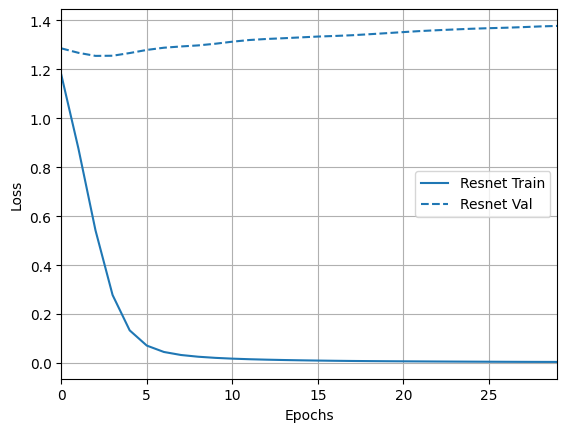

In [8]:
# plotting graphs to visualise the learning of the network
histories = {'resnet':history}
#Training loss and validation loss
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)


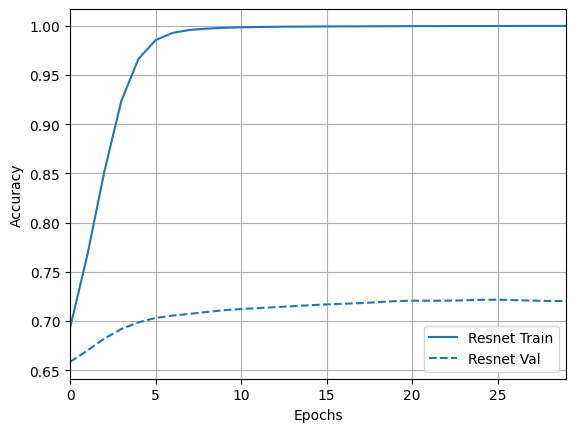

In [9]:
#Training accuracy and validation accuracy
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)

In [10]:
#Obtain the metric of the model when running on the train dataset
res = model_resnet.evaluate(train_ds)

1438/1438 [==============================] - 49s 34ms/step - loss: 5.3345e-04 - accuracy: 1.0000


In [11]:
#Obtain the metric of the model when running on the test dataset
res = model_resnet.evaluate(test_ds)

180/180 [==============================] - 6s 34ms/step - loss: 1.3781 - accuracy: 0.7151


### Best model (Unfreeze with augmentation and hyperparameter tuned)

In order to improve learning on such a small dataset, data augmentation was done on the training set. Neural Network architecture was also modified to achieve a better accuracy.

In [12]:
# For this set of data, we augmented the train dataset and no augmentation was done on the validation and test dataset
train_ds = image_generator.flow_from_directory(
  train_dir,
  shuffle = True,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

val_ds = image_generator_test.flow_from_directory(
  val_dir,
  shuffle = True,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

test_ds = image_generator_test.flow_from_directory(
  test_dir,
  shuffle = False,
  target_size = (img_size, img_size),
  class_mode = 'categorical',
  batch_size = batch_size
  )

Found 46000 images belonging to 23 classes.
Found 5750 images belonging to 23 classes.
Found 5750 images belonging to 23 classes.


Changes made: Hidden Nodes, optimizer(SGD/rmsprop), loss function(CC), early stoppage(DUN DO cos won't run) <br>
Change yet to be made: learning rate,hidden layers, model, batch size

In [13]:
# Early stoppage to prevent overfitting
def valid_callback(name):
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
           tfdocs.modeling.EpochDots()]

In [14]:
#Creation of model with best parameters
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (150,150,3), classes = len(train_ds.class_indices))
#Adding layers to the ResNet50
model_resnet=Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
model_resnet.add(Dense(320,activation='relu')) 
model_resnet.add(Dropout(0.30000000000000004))
model_resnet.add(Dense(512,activation='relu'))
model_resnet.add(Dropout(0.30000000000000004))
model_resnet.add(Dense(256,activation='relu'))
model_resnet.add(Dropout(0.30000000000000004))
model_resnet.add(Dense(len(train_ds.class_indices),activation=('softmax')))

#Compiling the model

model_resnet.compile(optimizer = tf.keras.optimizers.SGD(0.0006000000000000001), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])


In [15]:
# Fitting the model
epochs= 50
history = model_resnet.fit(train_ds,
                  validation_data = val_ds, 
                  callbacks = valid_callback('mnicmodel'),
                  epochs = epochs)

Epoch 1/50
1438/1438 [==============================] - ETA: 0s - loss: 3.0089 - accuracy: 0.1340
Epoch: 0, accuracy:0.1340,  loss:3.0089,  val_accuracy:0.4068,  val_loss:2.2023,  
1438/1438 [==============================] - 170s 116ms/step - loss: 3.0089 - accuracy: 0.1340 - val_loss: 2.2023 - val_accuracy: 0.4068
Epoch 2/50
1438/1438 [==============================] - 169s 118ms/step - loss: 2.2649 - accuracy: 0.3365 - val_loss: 1.5918 - val_accuracy: 0.5409
Epoch 3/50
1438/1438 [==============================] - 164s 114ms/step - loss: 1.8765 - accuracy: 0.4502 - val_loss: 1.3569 - val_accuracy: 0.6127
Epoch 4/50
1438/1438 [==============================] - 167s 116ms/step - loss: 1.6688 - accuracy: 0.5161 - val_loss: 1.2658 - val_accuracy: 0.6304
Epoch 5/50
1438/1438 [==============================] - 165s 115ms/step - loss: 1.5202 - accuracy: 0.5600 - val_loss: 1.1788 - val_accuracy: 0.6610
Epoch 6/50
1438/1438 [==============================] - 166s 116ms/step - loss: 1.4172 - a

Best: 800, 512,128 : 77.6<br>
1024,512,256,128: 0.6776<br>
1024,512,512,128: 0.6979<br>
512,256,128,64: 74<br>
baseline: 0.68 <br>
observation: 3 layers overfit


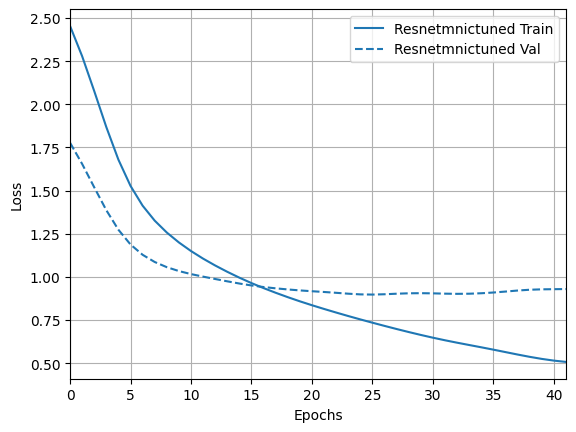

In [16]:
# plotting graphs to visualise the learning of the network
histories = {'resnetMNICTuned':history}
#Training loss and validation loss
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)


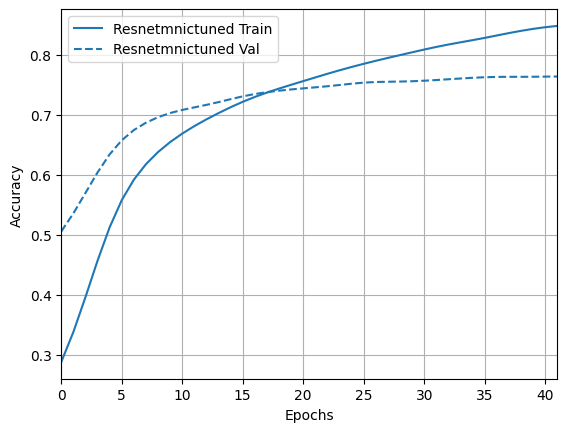

In [17]:
#Training accuracy and validation accuracy
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)

In [18]:
#Obtain the metric of the model when running on the test dataset
res = model_resnet.evaluate(test_ds)

180/180 [==============================] - 6s 31ms/step - loss: 0.9382 - accuracy: 0.7610


In [19]:
#Obtain the predictions of the model when running on the test dataset
pred = model_resnet.predict(test_ds, steps=len(test_ds), verbose=1)

180/180 [==============================] - 6s 29ms/step


In [20]:
#Obtaining the classes classified by the model
predicted_class_indices = np.argmax(pred, axis=1)

In [21]:
# Obtain the labels/ground truth from the test dataset
labels = (test_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [22]:
# creation a dataframe of the test data filenames against the classes predicted by the model
filenames = test_ds.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [23]:
results

,Filename,Predictions
0,brick\brick_000001.jpg,brick
1,brick\brick_000006.jpg,brick
2,brick\brick_000024.jpg,brick
3,brick\brick_000027.jpg,tile
4,brick\brick_000035.jpg,stone
...,...,...
5745,wood\wood_002456.jpg,wood
5746,wood\wood_002465.jpg,polishedstone
5747,wood\wood_002472.jpg,paper
5748,wood\wood_002475.jpg,wood


In [24]:
# output the results into a csv
results.to_csv("outmnic.csv", index=False)